In [1]:
# ML-Agents
from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.envs.unity_gym_env import UnityToGymWrapper
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel

# Reinforce Lab
from q_learning import QLearningAgent

# Imports
import numpy as np
from tqdm import tqdm

In [2]:
# Environment
channel = EngineConfigurationChannel()
unity_env = UnityEnvironment(file_name = 'windows/Factored-Workshop-2D.exe', seed=0, side_channels=[channel])

# Set speed
channel.set_configuration_parameters(time_scale = 10)

env = UnityToGymWrapper(
    unity_env=unity_env,
    flatten_branched=False, 
    allow_multiple_obs=False ,
    action_space_seed=None
    )

[WARNING] The environment contains multiple observations. You must define allow_multiple_obs=True to receive them all. Otherwise, only the first visual observation (or vector observation ifthere are no visual observations) will be provided in the observation.


In [3]:
# Let's transform coordinates to a natural number.
cord_to_idx = {}
idx = 0

for x in range(-2, 12):
    for y in range(0, 9):
        cord_to_idx[(x,y)] = idx
        idx += 1

# Set environment action size
env.custom_observation_space_dict = cord_to_idx

idx_to_cord = {v: k for k, v in cord_to_idx.items()}

In [4]:
def train(env, agent, path, num_epochs=1_000, epsilon=0.5, epsilon_decay=4e-6, min_epsilon=.01):
    loop = tqdm(range(num_epochs))
    best_avg_reward = float("-inf")
    rewards_history = []
    state_history = []

    for _ in loop:
        state = env.reset()
        
        # Transform (x,y)->idx
        state = cord_to_idx[tuple(state[:2])]
        state_history.append(state)

        epoch_cum_reward = 0
        while True:
            # Generate a RL interaction
            action = agent.act(state, epsilon=epsilon)
            next_state, reward, done, info = env.step(action)

            # Transform (x,y,z)->idx
            next_state = cord_to_idx[tuple(next_state[:2])]
            state_history.append(next_state)
            
            agent.update(state, action, reward, next_state, done)

            # Update epsilon
            epsilon = max(min_epsilon, epsilon * (1 - epsilon_decay))

            epoch_cum_reward += reward
            state = next_state

            if done:
                break

        # Show performance
        rewards_history.append(epoch_cum_reward)
        rewards_window = rewards_history[-100:]
        avg_reward = sum(rewards_window)/len(rewards_window)

        # Save best model
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            agent.save(path)

        loop.set_description(
            f"Avg 100eps Reward: {round(avg_reward, 4)} | Epsilon: {round(epsilon, 3)}")
    return rewards_history, state_history


def test(env, agent, num_episodes=100):
    cum_reward = 0
    rewards_history = []
    state_history = []

    for _ in tqdm(range(num_episodes)):
        state = env.reset()

        # Transform (x,y)->idx
        state = cord_to_idx[tuple(state[:2])]
        state_history.append(state)

        ep_cum_reward = 0
        while True:
            action = agent.act(state, epsilon=0)
            next_state, reward, done, info = env.step(action)
            ep_cum_reward += reward

            # Transform (x,y)->idx
            state = cord_to_idx[tuple(next_state[:2])]
            state_history.append(state)

            if done:
                break

        cum_reward += ep_cum_reward
        rewards_history.append(ep_cum_reward)

    avg_reward = cum_reward / num_episodes
    env.close()
    print(f"The agent obtained an average reward of {round(avg_reward, 4)} over {num_episodes} episode(s)")
    return rewards_history, state_history


# Train Agent
agent = QLearningAgent(env, gamma=0.9999, alpha=0.10)
path = "factored-workshop-agent"

rewards_history, state_history = train(env, agent, path, num_epochs=500, epsilon=0.2, epsilon_decay=1e-4, min_epsilon=.05)
agent.load(path)
training_rewards_history, training_state_history = test(env, agent)

Avg 100eps Reward: 0.907 | Epsilon: 0.05: 100%|██████████| 500/500 [06:32<00:00,  1.27it/s]   
100%|██████████| 100/100 [00:35<00:00,  2.85it/s]

The agent obtained an average reward of 1.0 over 100 episode(s)


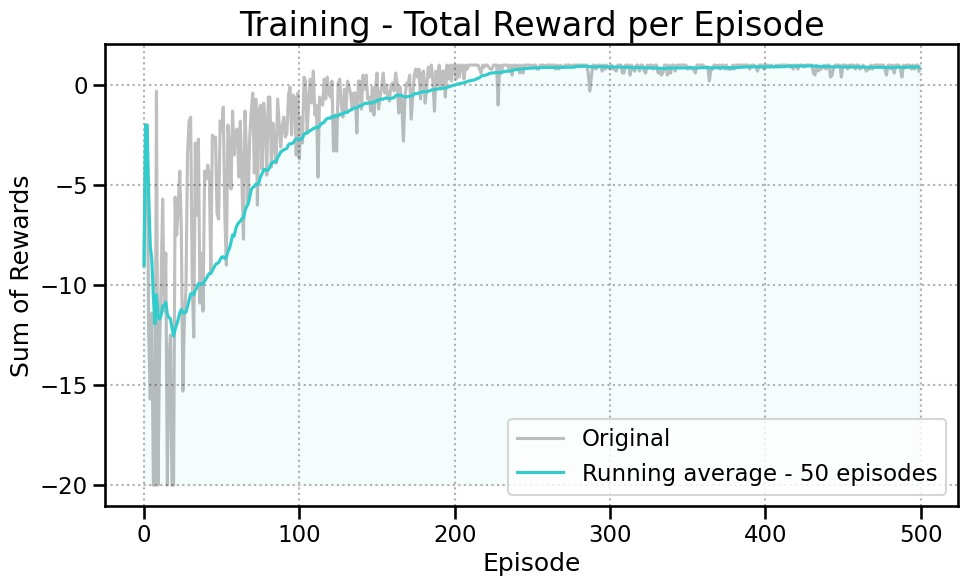

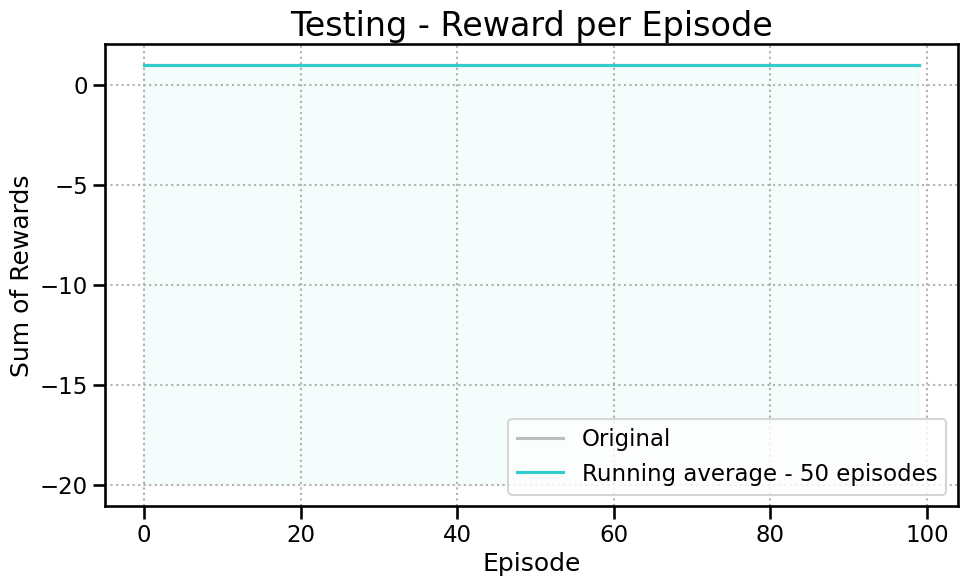

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_performance(scores, title = 'Reward', label='Running average - 50 episodes', window = 50):

    plt.figure(figsize=(11,6))
    sns.set_context("talk")

    # Get moving average
    cumsum = np.cumsum(scores)
    moving_average = [scores[0]]

    for i in range(1,len(cumsum)):
        moving_average.append((cumsum[i]-cumsum[max(0,i-window)])/len(cumsum[max(0,i-window):i]))

    plt.plot(scores, 'k-', label='Original', alpha=0.25)
    plt.plot(moving_average, '#33cccc', label=label)
    plt.ylabel('Sum of Rewards')
    plt.xlabel('Episode')
    plt.grid(linestyle=':')
    plt.fill_between(range(len(moving_average)), -20, moving_average, color='#33cccc', alpha=0.05)
    plt.legend(loc='lower right')
    plt.title(title, fontsize=24 )
    plt.show();

plot_performance(rewards_history, title='Training - Total Reward per Episode')
plot_performance(training_rewards_history, title='Testing - Reward per Episode' )

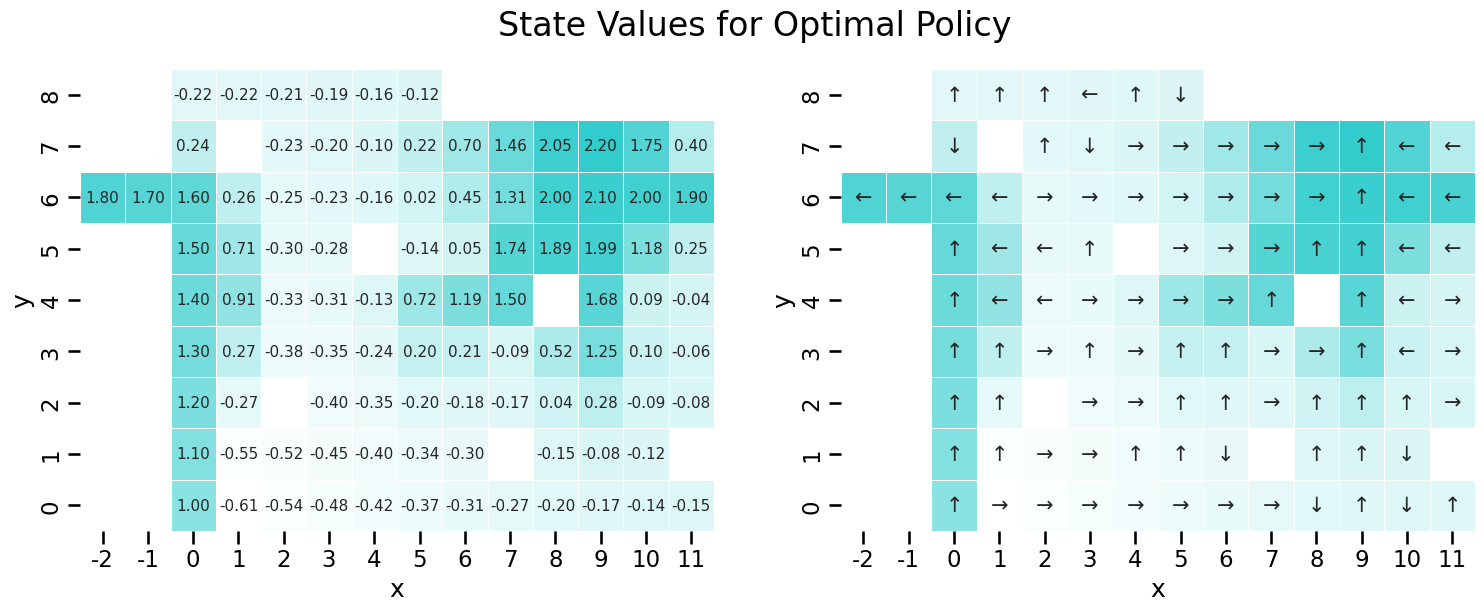

In [6]:
def plot_frozen_lake(qtable):

    # Custom color map
    import matplotlib.colors
    norm = matplotlib.colors.Normalize(-1,1)
    colors = [[norm(-1.0), "white"],
            [norm( 1.0), "#33cccc"]]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

    direction_dict = {3:"←", 2:"↓", 1:"→", 0:"↑"}

    df = pd.DataFrame(qtable)
    df['state_value'] = df.max(axis=1)
    df = df.reset_index()


    df["x"] = df['index'].apply(lambda x: idx_to_cord[x][0])
    df["y"] = df['index'].apply(lambda x: idx_to_cord[x][1])

    df['best_action'] = df[[0,1,2,3]].apply(lambda x: np.argmax(x), axis=1).apply(lambda x: direction_dict[x])
    df = df[df['state_value']!=0]

    df_state_values = df.pivot(columns='x', index='y', values='state_value').sort_index(ascending=False)
    df_best_action = df.pivot(columns='x', index='y', values='best_action').sort_index(ascending=False)

    fig, axes = plt.subplots(1, 2, figsize=(18,6))
    fig.suptitle('State Values for Optimal Policy', fontsize=24)
    sns.heatmap(df_state_values, annot=True, linewidths=.5, cbar=False, cmap=cmap, fmt = '.2f', ax=axes[0], annot_kws={"fontsize":11})
    sns.heatmap(df_state_values, annot=df_best_action, linewidths=.5, cbar=False, cmap=cmap, fmt = '', ax=axes[1], annot_kws={"fontsize":15})

    plt.show()


plot_frozen_lake(agent.qtable)

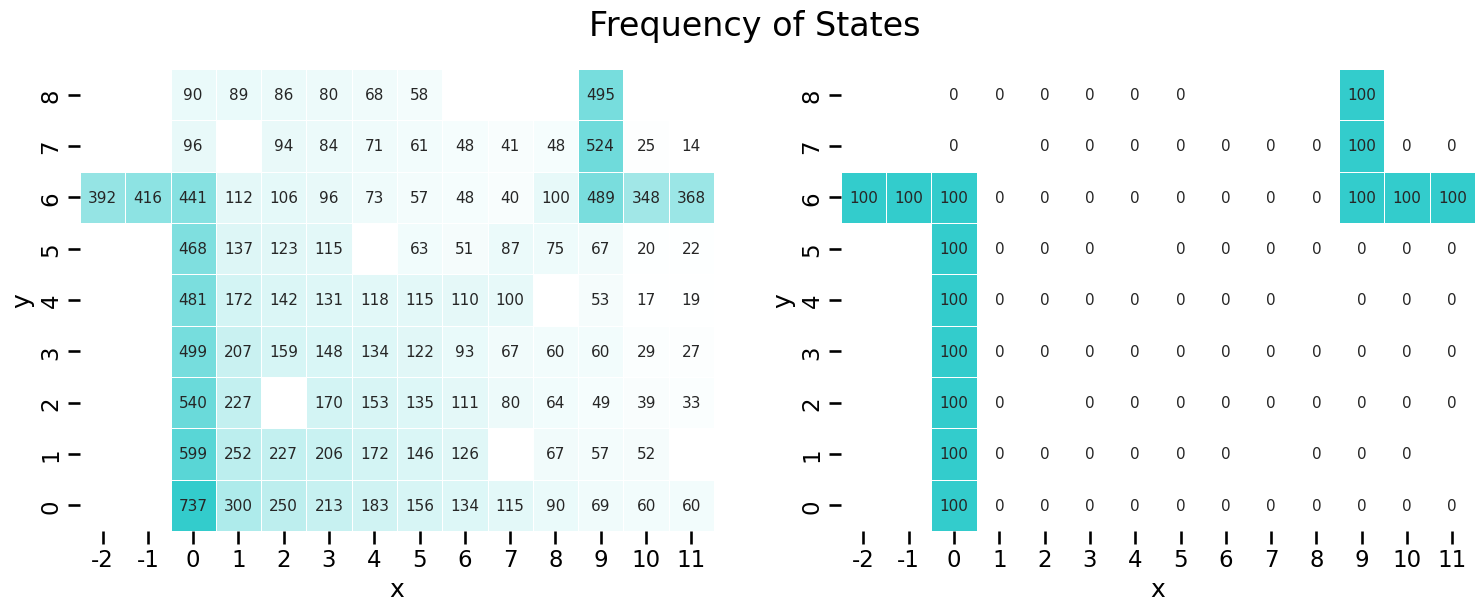

In [7]:
def plot_frequencies(state_history, training_state_history):

    import collections

    # Custom color map
    import matplotlib.colors
    norm = matplotlib.colors.Normalize(-1,1)
    colors = [[norm(-1.0), "white"],
            [norm( 1.0), "#33cccc"]]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

    # Traning
    training_counter = collections.Counter(state_history)
    df_training = pd.DataFrame()
    df_training["state"] = training_counter.keys()
    df_training['freq'] = training_counter.values()
    df_training["x"] = df_training['state'].apply(lambda x: idx_to_cord[x][0])
    df_training["y"] = df_training['state'].apply(lambda x: idx_to_cord[x][1])
    df_freqs_training = df_training.pivot(columns='x', index='y', values='freq').sort_index(ascending=False)

    # Testing
    testing_counter = collections.Counter(training_state_history)
    df_testing = pd.DataFrame()
    df_testing["state"] = testing_counter.keys()
    df_testing['freq'] = testing_counter.values()
    df_testing["x"] = df_testing['state'].apply(lambda x: idx_to_cord[x][0])
    df_testing["y"] = df_testing['state'].apply(lambda x: idx_to_cord[x][1])

    df_testing = df_training.merge(df_testing[['state', 'freq']], how='outer', on='state', suffixes=('', '_testing')).fillna(0)
    df_freqs_testing = df_testing.pivot(columns='x', index='y', values='freq_testing').sort_index(ascending=False)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(18,6))
    fig.suptitle('Frequency of States', fontsize=24)
    sns.heatmap(df_freqs_training, annot=True, linewidths=.5, cbar=False, cmap=cmap, fmt = 'g', ax=axes[0], annot_kws={"fontsize":11})
    sns.heatmap(df_freqs_testing, annot=True, linewidths=.5, cbar=False, cmap=cmap, fmt = 'g', ax=axes[1], annot_kws={"fontsize":11})

    plt.show()

plot_frequencies(state_history, training_state_history)